In [1]:
!pip install catboost
!pip install scikit-learn
!pip install seaborn
!pip install lightgbm
!pip install koreanize-matplotlib


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


# Import Library

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
import pandas as pd
import koreanize_matplotlib 
from scipy.stats import boxcox

warnings.filterwarnings(action='ignore')

# Data Load

In [3]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('./train.csv').drop(columns=['UID'])
test_df = pd.read_csv('./test.csv').drop(columns=['UID'])

In [4]:
train_df.head(5)

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
0,자가,1941337.5,10년 이상,0.0,9,13.4,400597.5,0,24,1,부채 통합,단기 상환,390903.0,225457.5,8806.5,767,0
1,월세,1979505.0,10년 이상,0.0,5,15.1,360679.5,0,11,0,부채 통합,단기 상환,1002184.5,64749.0,24961.5,767,0
2,월세,1356381.0,4년,0.0,12,18.8,491770.5,1,74,3,부채 통합,단기 상환,227775.0,487644.0,12069.0,800,1
3,월세,1049017.5,6년,0.0,15,14.8,411546.0,1,22,1,부채 통합,단기 상환,251383.5,413211.0,31749.0,796,1
4,월세,4320217.5,2년,0.0,11,26.1,895288.5,0,32,0,부채 통합,장기 상환,1163176.5,78991.5,5862.0,751,0


In [5]:
print(train_df.columns.tolist())

['주거 형태', '연간 소득', '현재 직장 근속 연수', '체납 세금 압류 횟수', '개설된 신용계좌 수', '신용 거래 연수', '최대 신용한도', '신용 문제 발생 횟수', '마지막 연체 이후 경과 개월 수', '개인 파산 횟수', '대출 목적', '대출 상환 기간', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액', '신용 점수', '채무 불이행 여부']


# EDA

In [6]:
# 채무 불이행 여부의 비율 확인
default_counts = train_df['채무 불이행 여부'].value_counts()
default_percentages = default_counts / default_counts.sum() * 100  # 퍼센트 계산

In [7]:
default_counts

채무 불이행 여부
0    6588
1    3412
Name: count, dtype: int64

In [8]:
train_df.describe()

,연간 소득,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
count,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.00000,10000.000000,10000.000000
mean,2.163959e+06,0.199300,12.248900,19.879360,1.175265e+06,0.62620,30.889200,0.373200,5.061200e+05,3.649126e+05,22367.28075,744.215000,0.341200
std,1.434430e+06,0.714304,4.620572,7.206693,1.604199e+06,1.23419,20.011561,0.843797,2.831462e+05,3.537942e+05,15186.49738,56.995698,0.474136
min,2.676210e+05,0.000000,2.000000,6.000000,0.000000e+00,0.00000,0.000000,0.000000,2.917650e+04,0.000000e+00,0.00000,502.000000,0.000000
25%,1.311437e+06,0.000000,9.000000,14.600000,4.482476e+05,0.00000,14.000000,0.000000,3.001901e+05,1.471856e+05,10893.75000,704.000000,0.000000
50%,1.743223e+06,0.000000,12.000000,17.950000,7.670910e+05,0.00000,28.000000,0.000000,4.743412e+05,2.547930e+05,20160.00000,756.000000,0.000000
75%,2.447664e+06,0.000000,15.000000,24.100000,1.147283e+06,1.00000,41.000000,0.000000,5.919079e+05,4.749180e+05,30647.25000,793.000000,1.000000
max,1.722975e+07,7.000000,35.000000,51.700000,2.323233e+07,7.00000,88.000000,3.000000,1.373613e+06,3.946300e+06,153574.50000,825.000000,1.000000


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  object 
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  object 
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  int64  
 5   신용 거래 연수           10000 non-null  float64
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  object 
 11  대출 상환 기간           10000 non-null  object 
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  int64  
 16  채무 불이행 여부          1000

In [10]:
train_df.isnull().sum()

주거 형태                0
연간 소득                0
현재 직장 근속 연수          0
체납 세금 압류 횟수          0
개설된 신용계좌 수           0
신용 거래 연수             0
최대 신용한도              0
신용 문제 발생 횟수          0
마지막 연체 이후 경과 개월 수    0
개인 파산 횟수             0
대출 목적                0
대출 상환 기간             0
현재 대출 잔액             0
현재 미상환 신용액           0
월 상환 부채액             0
신용 점수                0
채무 불이행 여부            0
dtype: int64

In [11]:
test_df.isnull().sum()

주거 형태                0
연간 소득                0
현재 직장 근속 연수          0
체납 세금 압류 횟수          0
개설된 신용계좌 수           0
신용 거래 연수             0
최대 신용한도              0
신용 문제 발생 횟수          0
마지막 연체 이후 경과 개월 수    0
개인 파산 횟수             0
대출 목적                0
대출 상환 기간             0
현재 대출 잔액             0
현재 미상환 신용액           0
월 상환 부채액             0
신용 점수                0
dtype: int64

# Graph Check

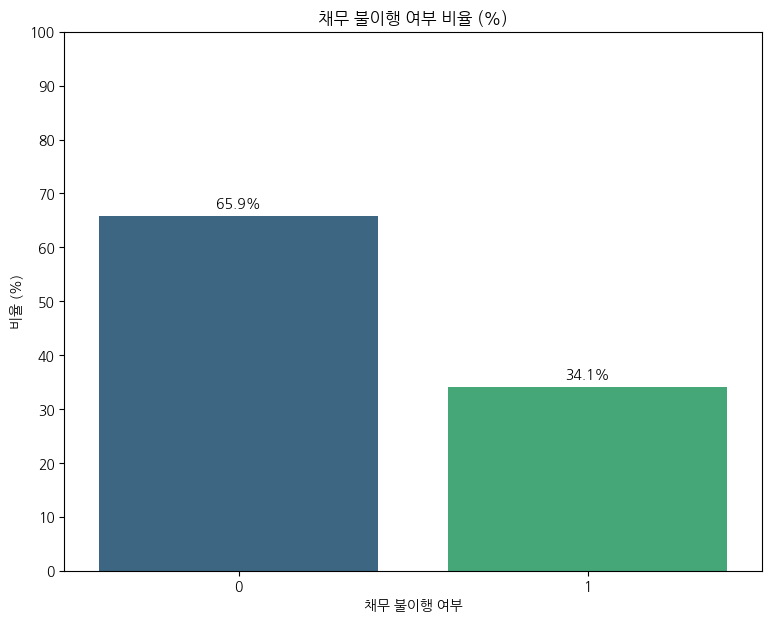

In [12]:
# 바 그래프 그리기
plt.figure(figsize=(9, 7))
sns.barplot(x=default_percentages.index, y=default_percentages.values, palette='viridis')

# 그래프 제목과 레이블 추가
plt.title('채무 불이행 여부 비율 (%)')
plt.xlabel('채무 불이행 여부')
plt.ylabel('비율 (%)')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
# y축 눈금을 퍼센트로 설정
plt.yticks(np.arange(0, 101, 10))  # 0부터 100까지 10 단위로 설정
plt.gca().set_ylim(0, 100)  # y축 범위 설정
# 퍼센트 값 텍스트 추가
for i, v in enumerate(default_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom')

# 그래프 표시
plt.show()

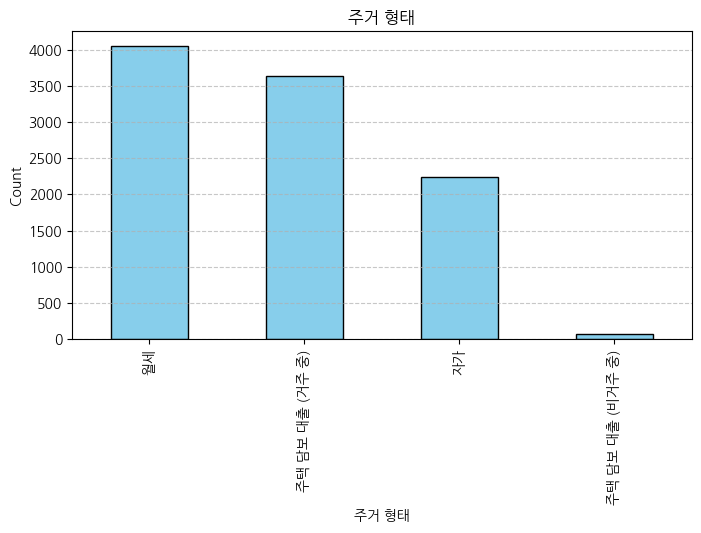

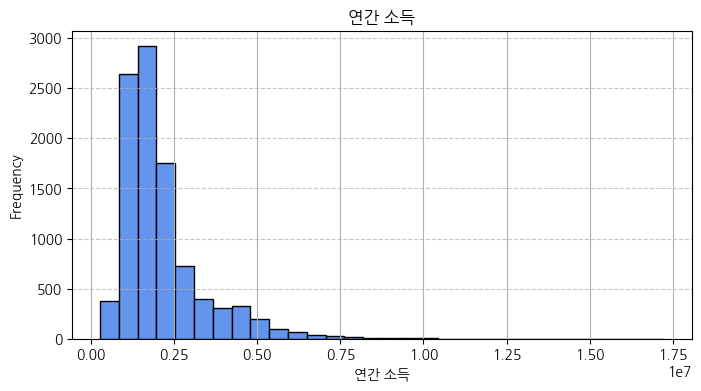

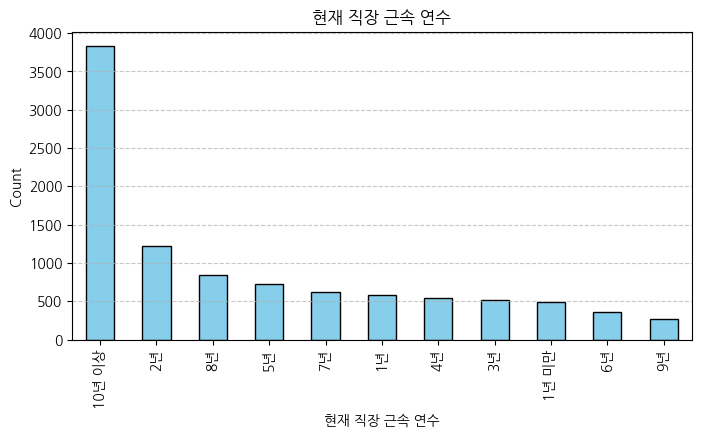

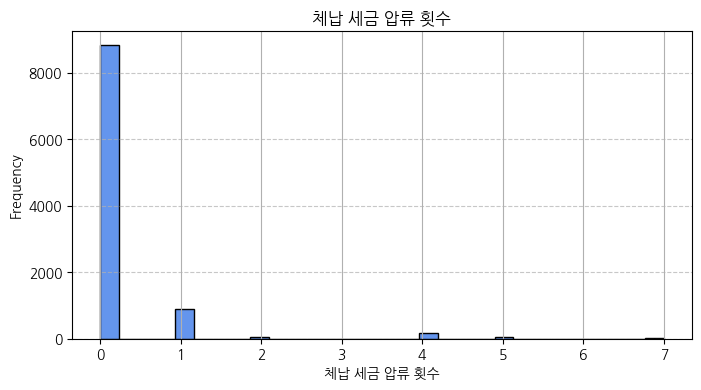

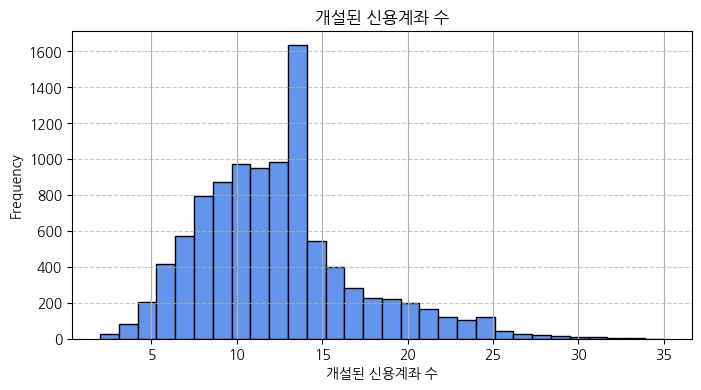

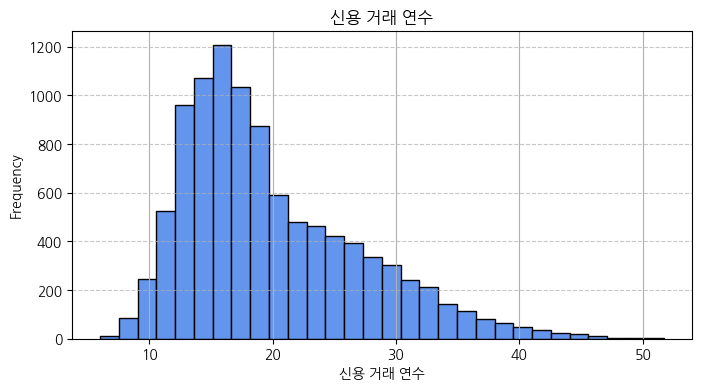

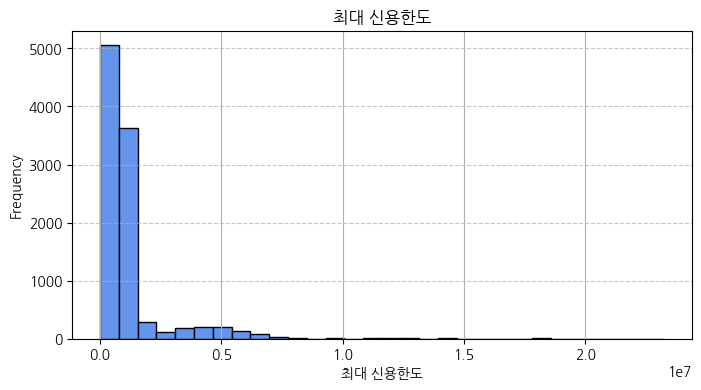

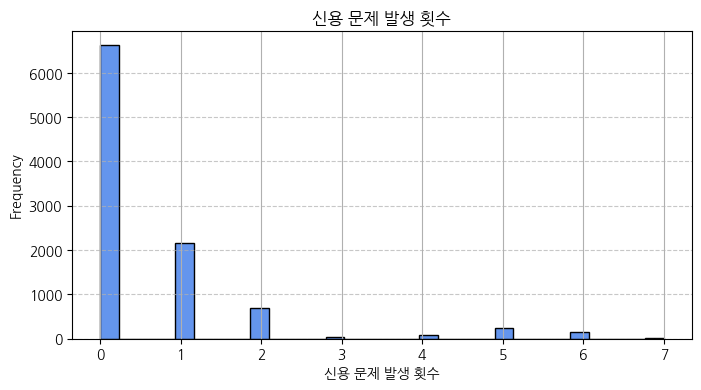

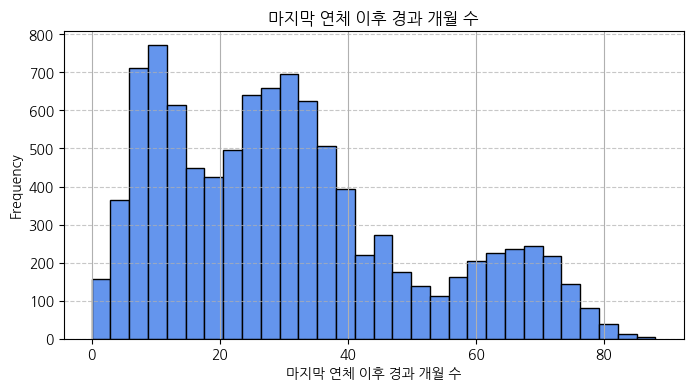

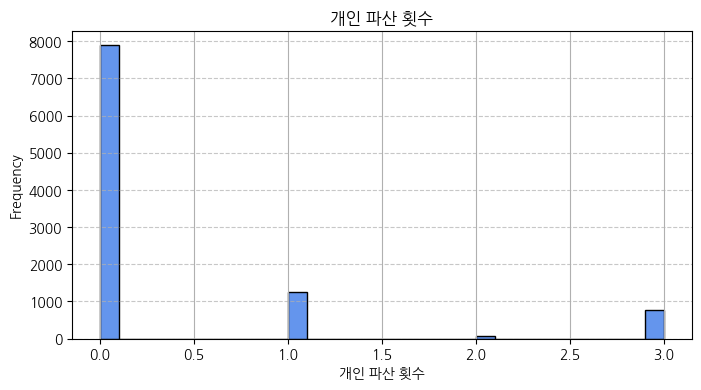

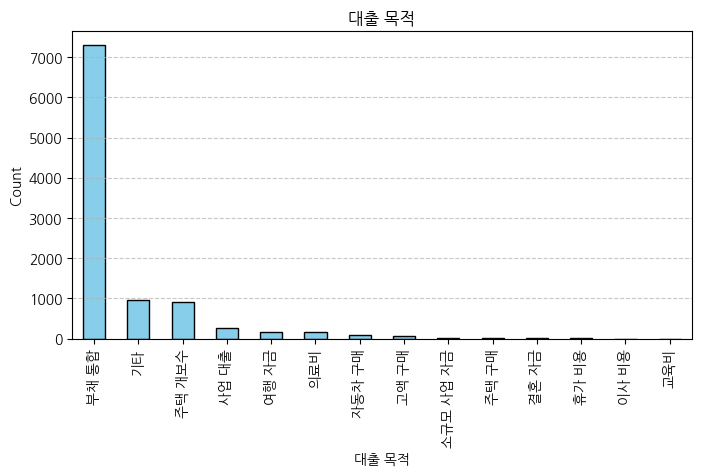

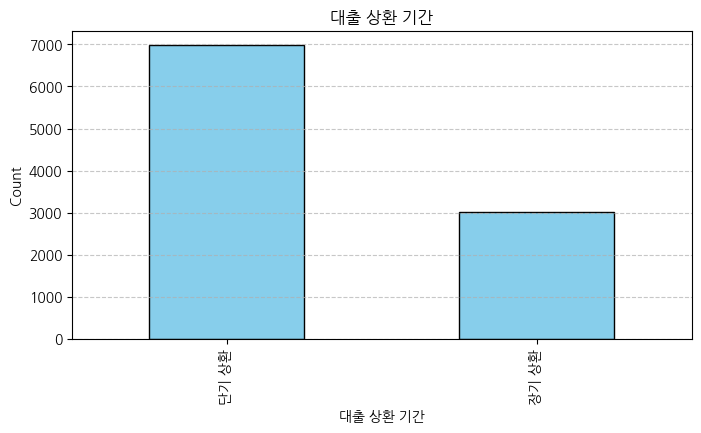

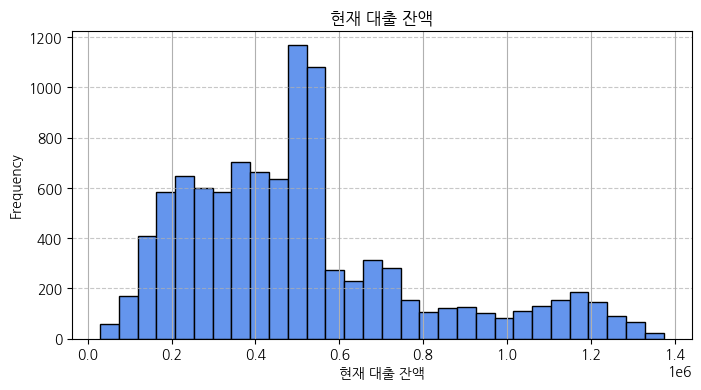

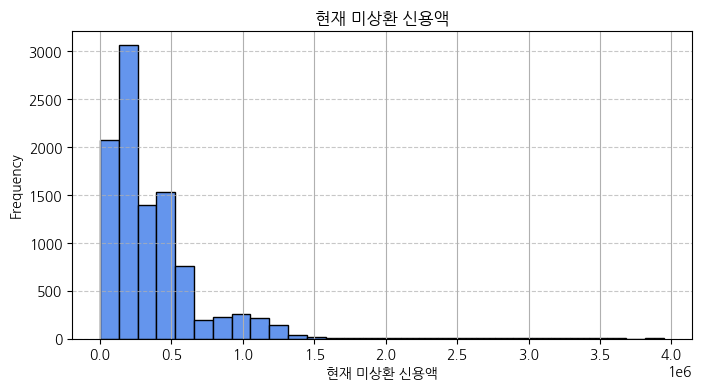

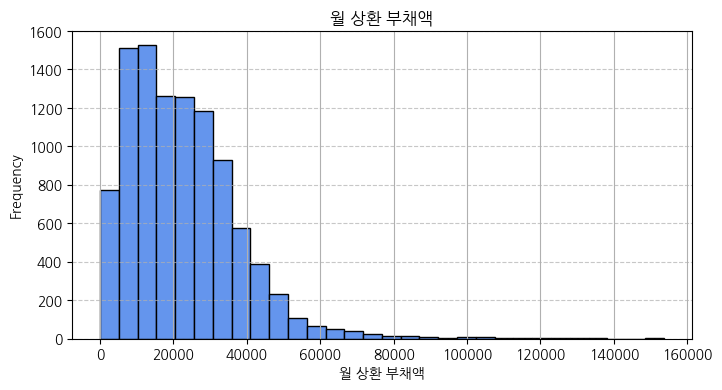

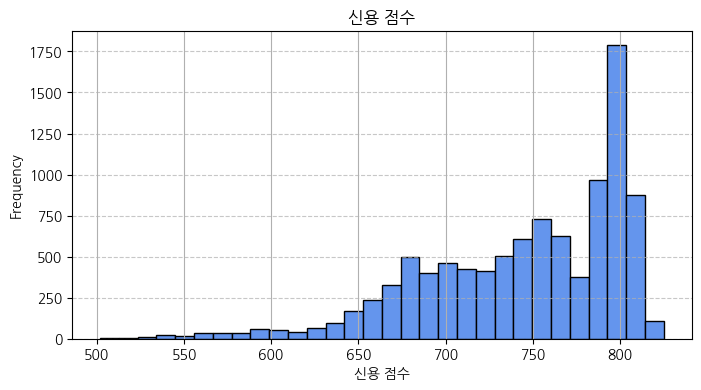

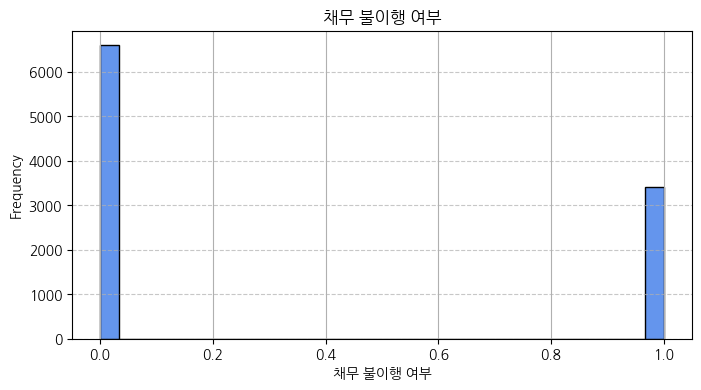

In [13]:
# 컬럼별 시각화
for col in train_df.columns:
    plt.figure(figsize=(8, 4))
    
    if train_df[col].dtype == 'object':  # 범주형 데이터
        train_df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.ylabel('Count')
    else:  # 수치형 데이터
        train_df[col].hist(bins=30, color='cornflowerblue', edgecolor='black')
        plt.ylabel('Frequency')
    
    plt.title(col)
    plt.xlabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Graph Check (Scatter)

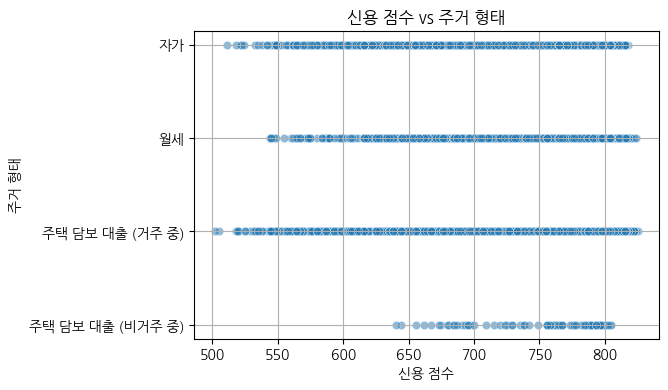

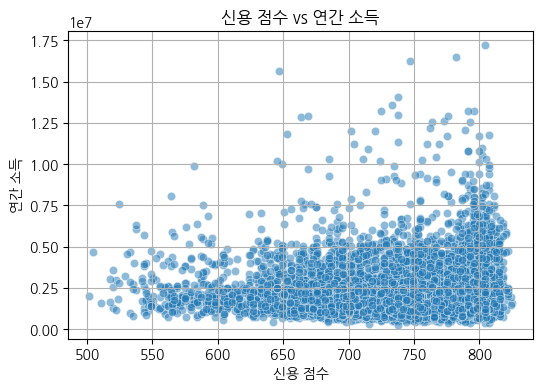

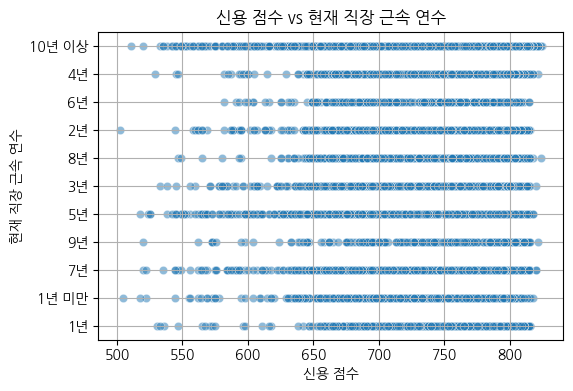

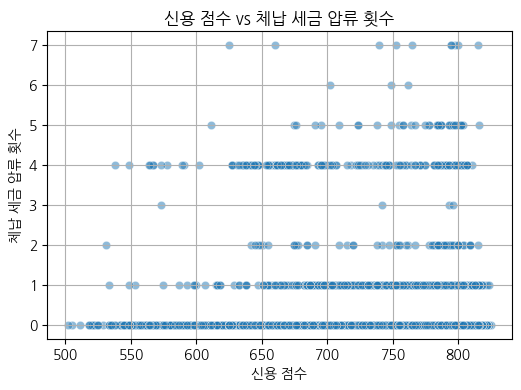

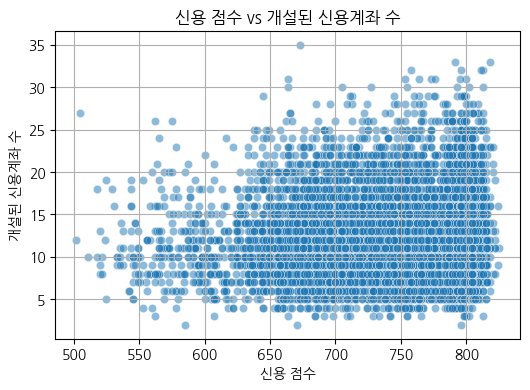

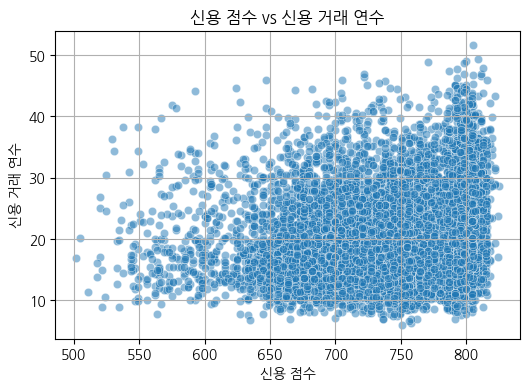

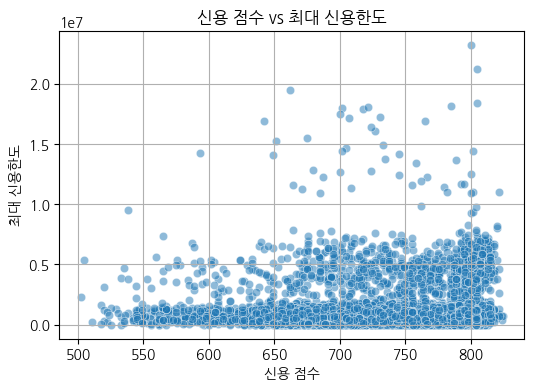

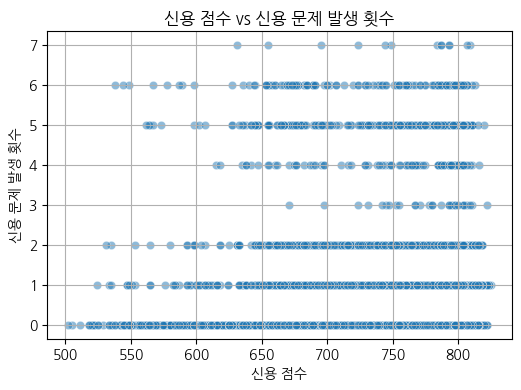

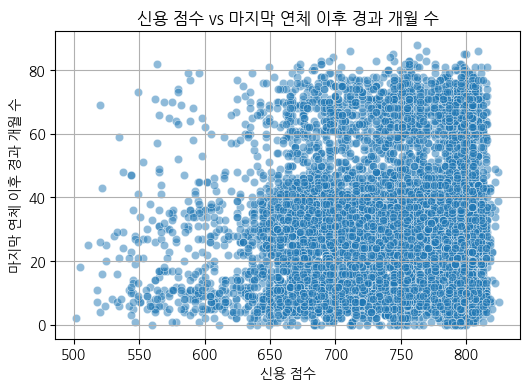

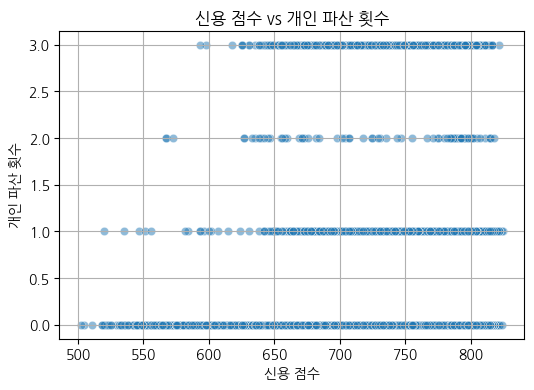

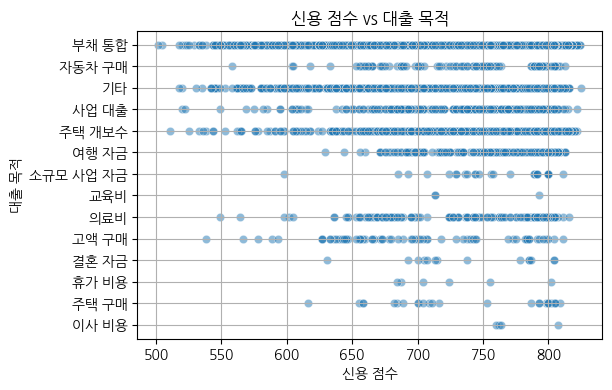

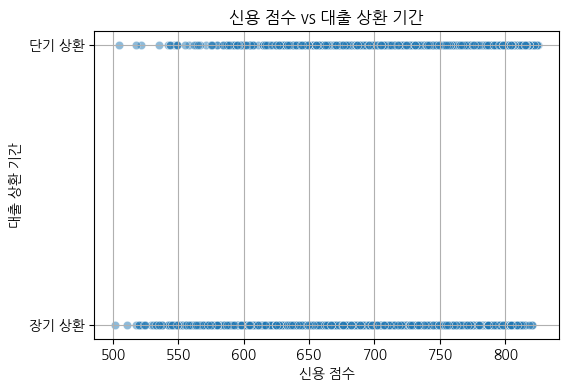

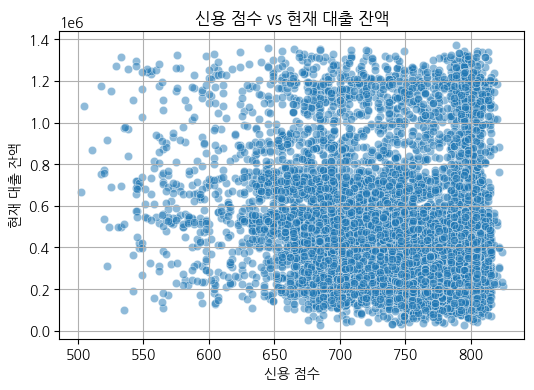

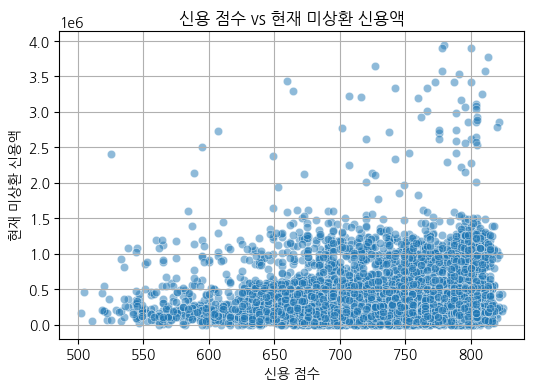

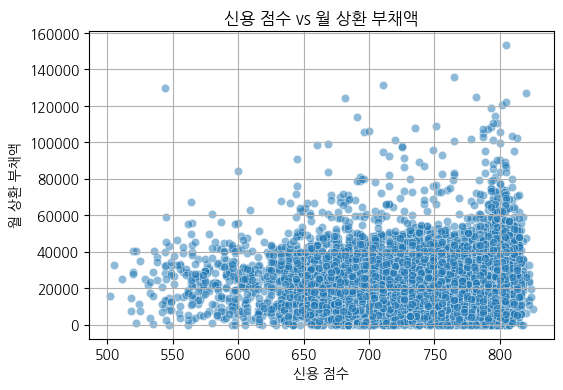

In [14]:
# '채무 불이행 여부' 컬럼을 제외한 데이터프레임 생성
filtered_columns = train_df.drop(columns=['채무 불이행 여부'])

# '신용 점수' 컬럼과 나머지 컬럼 간의 산점도 그리기
for column in filtered_columns.columns:
    if column != '신용 점수':  # '신용 점수' 자신과 비교하지 않도록 제외
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=train_df['신용 점수'], y=train_df[column], alpha=0.5)
        plt.title(f'신용 점수 vs {column}')
        plt.xlabel('신용 점수')
        plt.ylabel(column)
        plt.grid()
        plt.show()
        print()

# Add to New Columns

In [15]:
train_df['월 소득'] = train_df['연간 소득'] / 12
train_df['잔여 월 소득'] = train_df['월 소득'] - train_df['월 상환 부채액']

test_df['월 소득'] = test_df['연간 소득'] / 12
test_df['잔여 월 소득'] = test_df['월 소득'] - test_df['월 상환 부채액']

In [16]:
print(train_df.columns.tolist())

['주거 형태', '연간 소득', '현재 직장 근속 연수', '체납 세금 압류 횟수', '개설된 신용계좌 수', '신용 거래 연수', '최대 신용한도', '신용 문제 발생 횟수', '마지막 연체 이후 경과 개월 수', '개인 파산 횟수', '대출 목적', '대출 상환 기간', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액', '신용 점수', '채무 불이행 여부', '월 소득', '잔여 월 소득']


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  object 
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  object 
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  int64  
 5   신용 거래 연수           10000 non-null  float64
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  object 
 11  대출 상환 기간           10000 non-null  object 
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  int64  
 16  채무 불이행 여부          1000

# 왜도 보정

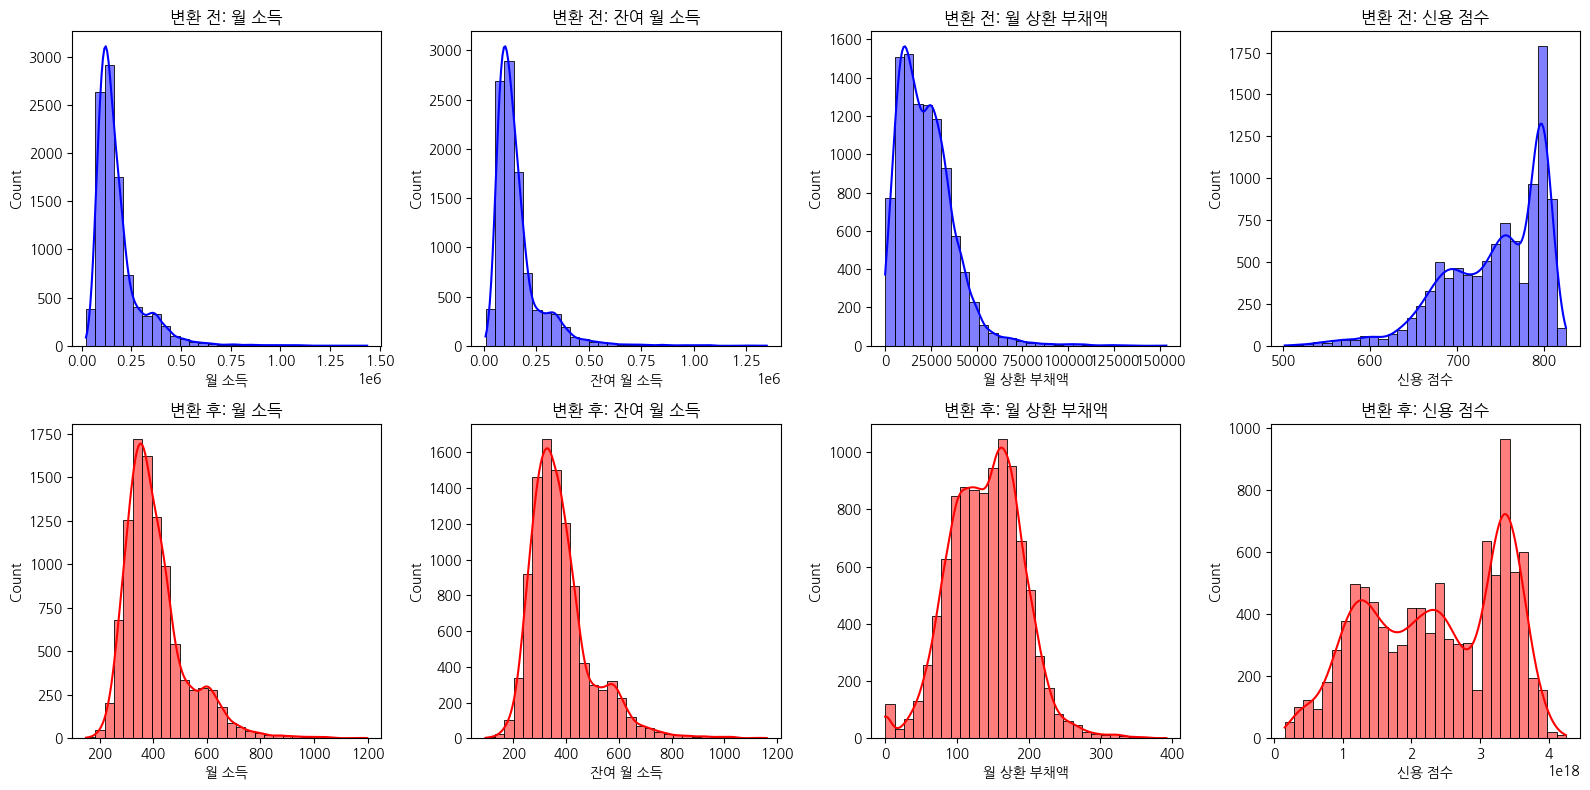

In [18]:


# 변환 전 데이터 복사
df_original = train_df.copy()

# 새로운 변환 적용
df_transformed = train_df.copy()
df_transformed["월 소득"] = np.sqrt(df_transformed["월 소득"])
df_transformed["잔여 월 소득"] = np.sqrt(df_transformed["잔여 월 소득"])
df_transformed["월 상환 부채액"] = np.sqrt(df_transformed["월 상환 부채액"])
df_transformed["신용 점수"], _ = boxcox(df_transformed["신용 점수"] + 1)

# 컬럼별 히스토그램 비교
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
columns = ["월 소득", "잔여 월 소득", "월 상환 부채액", "신용 점수"]

for i, col in enumerate(columns):
    # 변환 전
    sns.histplot(df_original[col], bins=30, kde=True, ax=axes[0, i], color="blue")
    axes[0, i].set_title(f"변환 전: {col}")

    # 변환 후
    sns.histplot(df_transformed[col], bins=30, kde=True, ax=axes[1, i], color="red")
    axes[1, i].set_title(f"변환 후: {col}")
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox

# Box-Cox 변환을 위한 lambda 값 저장 (train 데이터에서 구한 값을 사용해야 함)
_, boxcox_lambda = boxcox(train_df["신용 점수"] + 1)

# 변환 함수 정의
def transform_data(df):
    df["월 소득"] = np.sqrt(df["월 소득"])
    df["잔여 월 소득"] = np.sqrt(df["잔여 월 소득"])
    df["월 상환 부채액"] = np.sqrt(df["월 상환 부채액"])
    df["신용 점수"] = boxcox(df["신용 점수"] + 1, lmbda=boxcox_lambda)  # train에서 구한 λ 적용
    return df

# train_df & test_df 변환 적용
train_df = transform_data(train_df)
test_df = transform_data(test_df)

## Label Encoding

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 초기화
label_encoder = LabelEncoder()

# object 타입의 컬럼 선택
object_cols = train_df.select_dtypes(include=['object']).columns

# 각 object 컬럼에 대해 Label Encoding 적용
for col in object_cols:
    train_df[col] = label_encoder.fit_transform(train_df[col])
    test_df[col] = label_encoder.transform(test_df[col])  # test 데이터에 대해 동일한 인코더 사용

In [21]:
train_df

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부,월 소득,잔여 월 소득
0,1,1941337.5,0,0.0,9,13.4,400597.5,0,24,1,4,0,390903.0,225457.5,93.842954,2.617196e+18,0,402.216515,391.115872
1,0,1979505.0,0,0.0,5,15.1,360679.5,0,11,0,4,0,1002184.5,64749.0,157.992088,2.617196e+18,0,406.151142,374.162064
2,0,1356381.0,5,0.0,12,18.8,491770.5,1,74,3,4,0,227775.0,487644.0,109.859001,3.464845e+18,1,336.201948,317.746361
3,0,1049017.5,7,0.0,15,14.8,411546.0,1,22,1,4,0,251383.5,413211.0,178.182491,3.351078e+18,1,295.665563,235.943055
4,0,4320217.5,3,0.0,11,26.1,895288.5,0,32,0,4,1,1163176.5,78991.5,76.563699,2.274369e+18,0,600.015104,595.110179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,1339473.0,0,0.0,9,18.7,319027.5,0,68,0,4,0,126216.0,177028.5,78.974679,2.356273e+18,0,334.099910,324.631714
9996,2,2297230.5,3,0.0,11,28.3,399799.5,0,7,0,11,1,371907.0,347449.5,230.870093,1.521393e+18,0,437.533856,371.665004
9997,2,1221523.5,0,0.0,9,30.1,823305.0,0,14,0,4,1,869736.0,176905.5,106.939235,1.935055e+18,0,319.051132,300.595451
9998,1,3343584.0,0,0.0,10,20.3,724314.0,0,25,0,4,0,443008.5,139294.5,159.898405,1.370536e+18,0,527.856041,503.055166


In [22]:
# 각 컬럼의 최대값, 최소값, 평균 계산
max_values = train_df.max()
min_values = train_df.min()
mean_values = train_df.mean()

# 최대값, 최소값, 평균을 데이터프레임으로 결합
min_max_mean_df = pd.DataFrame({
    '최대값': max_values,
    '최소값': min_values,
    '평균': mean_values
})

min_max_mean_df

,최대값,최소값,평균
주거 형태,3.000000e+00,0.000000e+00,9.735000e-01
연간 소득,1.722975e+07,2.676210e+05,2.163959e+06
현재 직장 근속 연수,1.000000e+01,0.000000e+00,3.210300e+00
체납 세금 압류 횟수,7.000000e+00,0.000000e+00,1.993000e-01
개설된 신용계좌 수,3.500000e+01,2.000000e+00,1.224890e+01
신용 거래 연수,5.170000e+01,6.000000e+00,1.987936e+01
최대 신용한도,2.323233e+07,0.000000e+00,1.175265e+06
신용 문제 발생 횟수,7.000000e+00,0.000000e+00,6.262000e-01
마지막 연체 이후 경과 개월 수,8.800000e+01,0.000000e+00,3.088920e+01
개인 파산 횟수,3.000000e+00,0.000000e+00,3.732000e-01


# Correlation Value Check

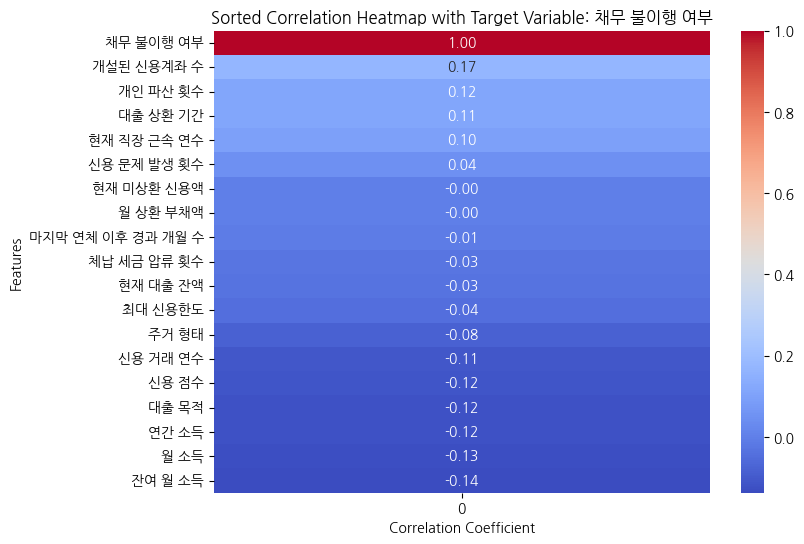

In [23]:
# 상관관계 행렬 계산
correlation_matrix = train_df.corr()

# 타겟 변수와의 상관관계 선택
target_correlation = correlation_matrix['채무 불이행 여부']

# 정렬
sorted_target_correlation = target_correlation.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(sorted_target_correlation.values.reshape(-1, 1), annot=True, fmt=".2f", cmap='coolwarm',
            yticklabels=sorted_target_correlation.index, cbar=True)
plt.title('Sorted Correlation Heatmap with Target Variable: 채무 불이행 여부')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


# Drop Columns

In [24]:
# 훈련 데이터를 X와 y로 나누기
X = train_df.drop(columns=['채무 불이행 여부', '현재 미상환 신용액','마지막 연체 이후 경과 개월 수', '체납 세금 압류 횟수', '개인 파산 횟수', '대출 목적', '최대 신용한도', '신용 거래 연수', '개설된 신용계좌 수', '연간 소득'])
y = train_df['채무 불이행 여부']

# 테스트 데이터에서 '현재 미상환 신용액' 제외
test_df = test_df.drop(columns=['현재 미상환 신용액','마지막 연체 이후 경과 개월 수', '체납 세금 압류 횟수', '개인 파산 횟수','대출 목적', '최대 신용한도', '신용 거래 연수', '개설된 신용계좌 수', '연간 소득'], errors='ignore')



In [25]:
# X의 컬럼 확인
print("X의 컬럼:")
print(X.columns.tolist())

X의 컬럼:
['주거 형태', '현재 직장 근속 연수', '신용 문제 발생 횟수', '대출 상환 기간', '현재 대출 잔액', '월 상환 부채액', '신용 점수', '월 소득', '잔여 월 소득']


# Data Scale & Hold Out

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier


# 데이터 스케일링
def scale_data(X_train, X_val, test_df):
    minmax_scaler = MinMaxScaler()
    X_train_scaled = minmax_scaler.fit_transform(X_train)
    X_val_scaled = minmax_scaler.transform(X_val)
    test_scaled = minmax_scaler.transform(test_df)
    return X_train_scaled, X_val_scaled, test_scaled

In [27]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# 스케일링 적용
X_train_scaled, X_val_scaled, test_scaled = scale_data(X_train, X_val, test_df)

In [28]:
print(X_train.shape)
print(X_val.shape)

(9000, 9)
(1000, 9)


# Ensemble (LGBM + Cat Boost)

In [29]:
# 모델 학습 및 예측 함수
def train_and_predict_lgbm(X_train, y_train, X_val):
    model = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.001,
        random_state=42,
        eval_metric='auc'
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    return model

def train_and_predict_catboost(X_train, y_train, X_val):
    model = CatBoostClassifier(
        iterations=22000,
        depth=5,
        learning_rate=0.0005,
        random_seed=42,
        verbose=500,
        eval_metric='AUC'
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    return model

In [30]:
# 각 모델 학습 및 예측
# model_extra_trees = train_and_predict_extra_trees(X_train_scaled, y_train, X_val_scaled)
model_lgbm = train_and_predict_lgbm(X_train_scaled, y_train, X_val_scaled)
model_catboost = train_and_predict_catboost(X_train_scaled, y_train, X_val_scaled)


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 3022, number of negative: 5978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 9
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335778 -> initscore=-0.682167
[LightGBM] [Info] Start training from score -0.682167
0:	test: 0.6282072	best: 0.6282072 (0)	total: 48.4ms	remaining: 17m 45s
500:	test: 0.6599327	best: 0.6650778 (7)	total: 968ms	remaining: 41.5s
1000:	test: 0.6640942	best: 0.6650778 (7)	total: 1.93s	remaining: 40.4s
1500:	test: 0.6679992	best: 0.6679992 (1500)	total: 2.9s	remaining: 39.6s
2

In [31]:
# 앙상블: 각 모델의 예측 결과를 평균하여 최종 예측
y_val_pred_lgbm = model_lgbm.predict_proba(X_val_scaled)[:, 1]
y_val_pred_catboost = model_catboost.predict_proba(X_val_scaled)[:, 1]
# y_val_pred_extra_trees  = model_extra_trees.predict_proba(X_val_scaled)[:, 1]

# 최종 예측
y_val_pred_ensemble = (y_val_pred_lgbm + y_val_pred_catboost) / 2

# ROC-AUC 평가
val_auc_ensemble = roc_auc_score(y_val, y_val_pred_ensemble)
print(f'앙상블 검증 데이터 ROC-AUC: {val_auc_ensemble:.4f}')

# [LightGBM] [Warning] Unknown parameter: eval_metric
# 앙상블 검증 데이터 ROC-AUC: 0.6808

[LightGBM] [Warning] Unknown parameter: eval_metric
앙상블 검증 데이터 ROC-AUC: 0.6810


In [32]:
# 채무 불이행 '확률'을 예측합니다.
preds_lgbm = model_lgbm.predict_proba(test_scaled)[:, 1]
preds_catboost = model_catboost.predict_proba(test_scaled)[:, 1]
# preds_extra_trees  = model_extra_trees.predict_proba(test_scaled)[:, 1]

# 최종 테스트 예측 앙상블
preds_ensemble = (preds_lgbm + preds_catboost) / 2

[LightGBM] [Warning] Unknown parameter: eval_metric


# Submission

In [36]:
# 결과 저장
submit = pd.read_csv('./sample_submission.csv')
submit['채무 불이행 확률'] = preds_ensemble
submit.to_csv('./submission_model_ensemble_final2.csv', encoding='UTF-8-sig', index=False)